<a href="https://colab.research.google.com/github/dknop/APMA_Election_Forecast/blob/main/BayesianModelForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sn
from matplotlib.colors import LogNorm, Normalize

In [2]:
states = ['AZ', 'PA','FL', 'GA', 
            'MI', "NV", 'TX', 'WI',
            'IA', 'NH', 'NC', 'OH']
means= [-.01593, -.01051, -.01965, -.03842,
        -.00129, -.01292, -.06286, -.01883,
        -.0285, -.0088, -.0292, -.0495]
variances = [.00028118, .00020964, .00027078, .00049740,
             0.00026277, .00040855, .00028620, .00028132,
             .00028145, .00033046,.00024605, .00021826]
elec_votes = [20, 11, 29, 16,
              16, 6, 38, 10,
              6, 4, 15, 18]
dem_won = [1,1,0,1,
           1,1,0,1,
           0,1,0,0]
p = 0.5144
v_p = .00058751

In [3]:
Z_means = np.array(means) +p
Z_variances = np.array(variances) + v_p
Z_s = (Z_means -0.5)/ np.sqrt(Z_variances)
probabilities = ss.norm().cdf(Z_s)

In [4]:
df= pd.DataFrame()
df['states'] = states
df['means'] = means
df['variances'] = variances
df['elec_votes'] = elec_votes
df['dem_won'] = dem_won
df['z'] = Z_s
df['prob'] = probabilities

In [28]:
def simulate_election(df = df,  p0 = p , variance_p0 = v_p, printit = False):

  # Starting electoral votes of the non-swing states for Trump and Biden
  Biden_points = 223
  Trump_points = 126

  # Sample of popular vote based off posterior distribution of p_0
  p_sample = np.random.normal(p0, np.sqrt(variance_p0))

  # Iterates through each swing state
  for ind in df.index:
    state = df.loc[ind]

    # State relative position (d_s,0)
    d_mean = state.means
    d_variance = state.variances
    d_std = np.sqrt(d_variance)

    # Sample of relative position based off posterior distribution of d_s,0
    d_sample = np.random.normal(d_std)

    # Proportion of votes Biden received in the sample
    biden_votes = p_sample + d_sample

    # Allocate electoral votes based on sample winner of state
    if biden_votes > .5:
      if printit:
        print ("Biden won", state.states)
      Biden_points += state.elec_votes
    else:
      Trump_points += state.elec_votes
      if printit:
        print ("Trump won", state.states)
      
  # Return total Biden electoral votes won
  return Biden_points

In [29]:
simulate_election(printit = True)

Biden won AZ
Trump won PA
Trump won FL
Biden won GA
Biden won MI
Trump won NV
Trump won TX
Biden won WI
Biden won IA
Trump won NH
Trump won NC
Trump won OH


291

In [30]:
results = np.array([simulate_election() for i in range (10000)])


In [31]:
print("Mean:", results.mean())
print("Standard Deviation:",results.std())
print("Proportion Biden Wins:", len(results[results>=270])/10000)

Mean: 320.1153
Standard Deviation: 32.02464060547752
Proportion Biden Wins: 0.9428


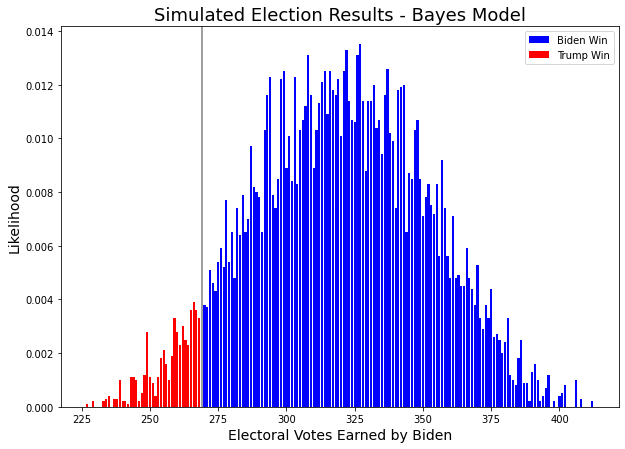

In [18]:
values,total_counts = np.unique(results,return_counts=True)
dems, counts_dems = np.unique(results[results>=270],return_counts=True)
reps, counts_reps = np.unique(results[results<=268],return_counts=True)
plt.figure(figsize = (10,7))
plt.bar(dems,counts_dems/np.sum(total_counts),label="Biden Win", color = 'blue')
plt.bar(reps,counts_reps/np.sum(total_counts),label="Trump Win", color = 'red')
plt.axvline(269, color = 'gray')
plt.title('Simulated Election Results - Bayes Model', fontsize = 18)
plt.xlabel("Electoral Votes Earned by Biden", fontsize = 14)
plt.ylabel ("Likelihood", fontsize = 14)
plt.legend()
plt.show()

In [19]:
def simulate_election_metrics(df = df,  p = p , v_p = v_p):
  # Starting electoral votes of the non-swing states for Trump and Biden
  Biden_points = 223
  Trump_points = 126

  correct_votes = 0
  correct_states = 0
  p_sample = np.random.normal(p, np.sqrt(v_p))
  brier_score = 0
  ind_states= []
  Biden_p = -1
  Trump_p = -1
  for ind in df.index:
    row = df.loc[ind]
    brier_score += (row.prob - row.dem_won)**2
    d_mean = row.means
    d_variances = row.variances
    d_std = np.sqrt(d_variances)
    d_sample = np.random.normal(d_std)
    biden_votes = p_sample + d_sample
    if biden_votes > .5:
      Biden_points += row.elec_votes
      if row.dem_won == 1:
        correct_votes += row.elec_votes
        correct_states +=1
      ind_states.append (1)
      
    else:
      Trump_points += row.elec_votes
      if row.dem_won == 0:
        correct_votes +=row.elec_votes
        correct_states +=1 
      ind_states.append(0)
  if Biden_points >=270:
    Biden_p = p_sample
  else:
    Trump_p =p_sample
  
  return correct_votes, correct_states, brier_score/12,ind_states,Biden_p, Trump_p

In [21]:
Biden_p = np.array([simulate_election_metrics ()[4] for i in range (1000)])
np.mean(Biden_p[Biden_p > 0])

0.5151710584883102

In [22]:
Trump_p = np.array([simulate_election_metrics ()[5] for i in range (1000)])
np.mean(Trump_p[Trump_p>0])

0.516063592672914

In [26]:
elec_votes_correct = np.array([simulate_election_metrics()[0] for i in range (1000)])
states_correct = np.array([simulate_election_metrics()[1] for i in range (1000)])
brier_score = simulate_election_metrics()[2]
print ("Elec Votes Correct:", np.mean(elec_votes_correct))
print ("States Correct", np.mean(states_correct))
print ("Brier Score", brier_score)

Elec Votes Correct: 95.298
States Correct 6.058
Brier Score 0.1901683238597867


In [42]:
matrix = np.array([simulate_election_metrics()[3] for i in range (10000)])
mat = pd.DataFrame(matrix, columns = states)


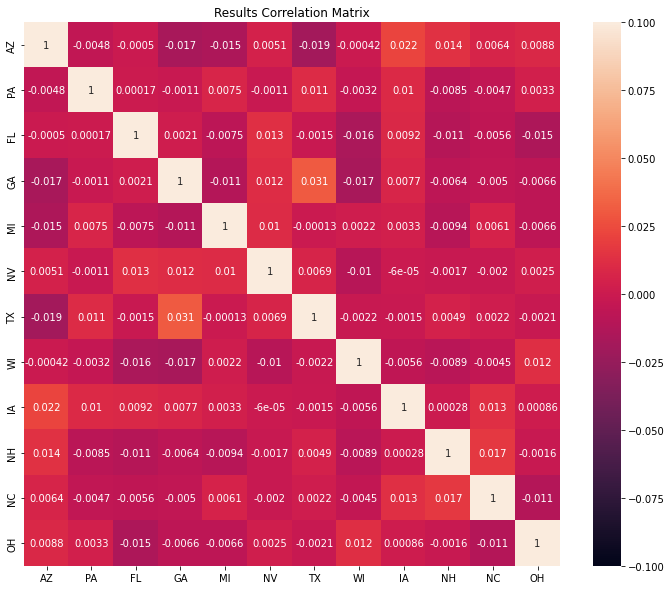

In [86]:
plt.figure(figsize = (12,10))
corrMatrix = mat.corr()
min1 = corrMatrix.min().min()
min2 = corrMatrix.max().max()
sn.heatmap(corrMatrix, annot=True,norm= Normalize(vmin=-.1, vmax=.1))
plt.title("Results Correlation Matrix")
plt.show()

In [47]:
min1 = corrMatrix.min()
min1.min()

-0.018756993706625393

In [26]:
matrix.shape

(10000, 12)

In [ ]:
results.std()

31.716654832280152

In [18]:
brier_score

0.16068478333395964